# Modeling

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import config
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
import plotly.express as px

In [2]:
import sqlalchemy
database_username = config.user
database_password = config.password
database_ip       = config.host
database_name     = 'Passengers'
conn = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [153]:
df = pd.read_sql("""SELECT * 
                    FROM Passengers.city_data
                    WHERE year < 2019""", con=conn, index_col='index')

df.head()

,ds,city,PASSENGERS,Type,Month,Year,temperature_mean,precipitation,rain_days,pressure,cost_of_living_index,population,city_ascii,lat,lng,country,iso2,iso3
index,,,,,,,,,,,,,,,,,,
0,2010-01-01,Atlanta,2735491,Domestic,1,2010,3.6,137.0,7.0,1019.50,100.99,429193.0,Atlanta,33.7627,-84.4225,United States,US,USA
1,2010-01-01,Washington,1929494,Domestic,1,2010,0.4,57.0,8.0,1016.70,98.19,605085.0,Washington,38.9047,-77.0163,United States,US,USA
2,2010-01-01,Singapore,1681005,International,1,2010,27.5,70.0,8.0,1011.60,65.94,5074252.0,Singapore,1.2930,103.8558,Singapore,SG,SGP
3,2010-01-01,Berlin,489487,International,1,2010,-4.9,21.0,7.0,1014.78,115.24,3450395.0,Berlin,52.5218,13.4015,Germany,DE,DEU
4,2010-01-01,Paris,4154249,International,1,2010,0.6,36.0,7.0,1015.60,130.30,10460118.0,Paris,48.8667,2.3333,France,FR,FRA


### Differencing

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [167]:
total_monthly = pd.DataFrame(df.groupby('ds')['PASSENGERS', 'temperature_mean'].sum())
total_monthly.head()

,PASSENGERS,temperature_mean
ds,,
2010-01-01,65294603,302.6
2010-02-01,61776883,354.1
2010-03-01,75170214,530.4
2010-04-01,71474034,696.7
2010-05-01,76526230,844.0


In [88]:
moving_average = total_monthly.rolling(window=12, min_periods=3).mean()
moving_average.head()

,PASSENGERS
ds,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,1.567765e+06
2010-04-01,1.591371e+06
2010-05-01,1.629032e+06


In [112]:
# Use Pandas ewm() to calculate Exponential Weighted Moving Average
exp_roll_mean = total_monthly.ewm(halflife=2).mean()

In [113]:
px.line(exp_roll_mean.reset_index(), 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using EWM'
        )

In [114]:
total_monthly

,PASSENGERS
ds,
2010-01-01,1.518479e+06
2010-02-01,1.436672e+06
2010-03-01,1.748145e+06
2010-04-01,1.662187e+06
2010-05-01,1.779680e+06
...,...
2018-08-01,2.704942e+06
2018-09-01,2.391084e+06
2018-10-01,2.487751e+06


In [115]:
# Subtract the moving average from the original data
data_minus_exp_roll_mean = total_monthly - exp_roll_mean
data_minus_exp_roll_mean

,PASSENGERS
ds,
2010-01-01,0.000000
2010-02-01,-33885.751922
2010-03-01,151817.405394
2010-04-01,40139.906182
2010-05-01,101548.917769
...,...
2018-08-01,148196.432648
2018-09-01,-117140.516323
2018-10-01,-14476.978671


In [117]:
px.line(data_minus_exp_roll_mean.reset_index(), 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using EWM'
        )

In [139]:
data_diff = data_minus_exp_roll_mean.diff(periods=12)

In [140]:
data_diff

,PASSENGERS
ds,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,NaN
2010-04-01,NaN
2010-05-01,NaN
...,...
2018-08-01,3649.995285
2018-09-01,-13927.819826
2018-10-01,-20161.854915


In [141]:
data_diff.reset_index(inplace=True)

In [143]:
px.line(data_diff, 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using EWM + Differencing'
        )

In [146]:
data_remove_trend = total_monthly - moving_average
data_remove_trend.head()

,PASSENGERS
ds,
2010-01-01,NaN
2010-02-01,NaN
2010-03-01,180379.395349
2010-04-01,70816.290698
2010-05-01,150647.376744


In [147]:
# Drop the missing values from time series calculated above
data_remove_trend.dropna(inplace=True)

In [75]:
data_remove_trend.reset_index(inplace=True)

In [148]:
px.line(data_remove_trend.reset_index(), 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using MA'
        )

We'll take the difference of one year/12 months from the data because of the annual seasonality observed.

In [149]:
data_diff = data_remove_trend.diff(periods=12)

In [150]:
data_diff

,PASSENGERS
ds,
2010-03-01,NaN
2010-04-01,NaN
2010-05-01,NaN
2010-06-01,NaN
2010-07-01,NaN
...,...
2018-08-01,19081.889535
2018-09-01,-10164.606589
2018-10-01,-22536.674419


In [151]:
data_diff.reset_index(inplace=True)

In [126]:
data_diff

,index,ds,PASSENGERS
0,0,NaT,NaN
1,1,NaT,NaN
2,2,NaT,NaN
3,3,NaT,NaN
4,4,NaT,NaN
...,...,...,...
101,101,365 days,19081.889535
102,102,365 days,-10164.606589
103,103,365 days,-22536.674419
104,104,365 days,-26471.802326


In [152]:
px.line(data_diff, 
        x='ds', 
        y="PASSENGERS", 
        title='Total Average Passengers: Trend Removed using MA + Differencing'
        )

## Decomposition

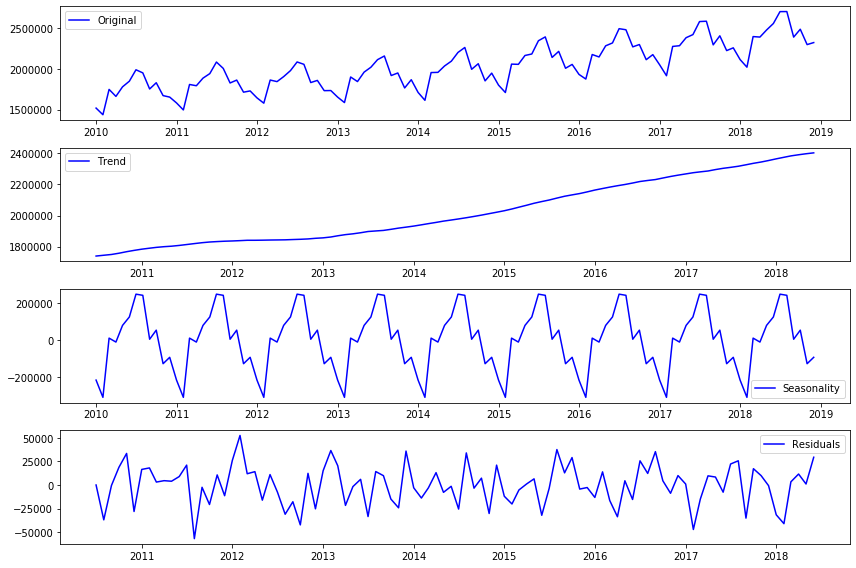

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(total_monthly)

# Gather the trend, seasonality and noise of decomposed object
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(total_monthly, label='Original', color="blue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='best')
plt.tight_layout()

## ACF & PACF

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


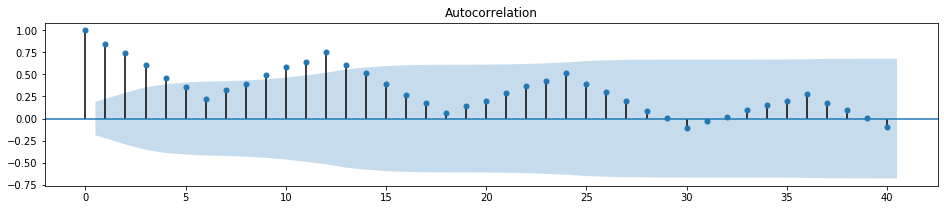

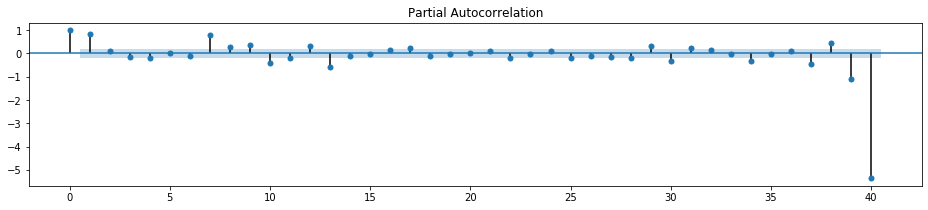

In [13]:
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(df,ax=ax, lags=40);

fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(df,ax=ax, lags=40);

## ARMA

In [31]:
# Fit an AR(1) model to the first simulated data
mod_arma = ARMA(df, order=(1,6))
res_arma = mod_arma.fit()

# Print out summary information on the fit
print(res_arma.summary())

# Print out the estimate for the constant and for theta
print(res_arma.params)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:             PASSENGERS   No. Observations:                  108
Model:                     ARMA(1, 6)   Log Likelihood               -1402.271
Method:                       css-mle   S.D. of innovations         100245.849
Date:                Thu, 16 Jan 2020   AIC                           2822.543
Time:                        15:11:17   BIC                           2846.682
Sample:                    01-01-2010   HQIC                          2832.330
                         - 12-01-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.031e+06   2.32e+05      8.741      0.000    1.58e+06    2.49e+06
ar.L1.PASSENGERS     0.9904      0.014     71.852      0.000       0.963       1.017
ma.L1.PASSENGERS    -0.3652 

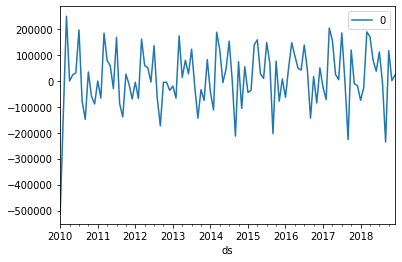

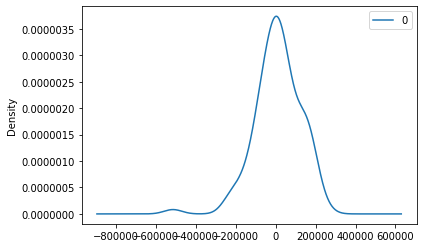

                   0
count     108.000000
mean    11357.022460
std    114555.842654
min   -512881.699814
25%    -61214.827901
50%      7646.834933
75%     78684.452967
max    248374.373622


In [34]:
residuals = pd.DataFrame(res_arma.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [164]:
size = int(len(df) * 0.7)
train, test = total_monthly[0:size], total_monthly[size:len(df)]

In [165]:
from pmdarima import auto_arima                              # for determining ARIMA orders


# For SARIMA Orders we set seasonal=True and pass in an m value
auto_arima(train['PASSENGERS'],seasonal=True,m=12).summary()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood               -1128.804
Date:                            Thu, 16 Jan 2020   AIC                           2259.609
Time:                                    18:19:31   BIC                           2262.163
Sample:                                         0   HQIC                          2260.641
                                            - 108                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.069e+09   1.31e+08      8.172      0.000    8.12e+08    1.32e+09
===================================================================================
Ljung-Box (Q):                       88.00   Jarque-Bera (JB):                 0.88
Prob(Q):                              0.00   Prob(JB):                         0.64
Heteroskedasticity (H):               1.34   Skew:                             0.22
Prob(H) (two-sided):                  0.42   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## SARIMAX on Average Passengers Across all Destinations

In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train,order=(0, 1, 0),seasonal_order=(0,1,0,12))
results = model.fit()

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [41]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                         PASSENGERS   No. Observations:                   75
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -736.003
Date:                            Thu, 16 Jan 2020   AIC                           1474.007
Time:                                    15:22:37   BIC                           1476.134
Sample:                                01-01-2010   HQIC                          1474.842
                                     - 03-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.716e+08   1.37e+08      7.113      0.000    7.04e+08    1.24e+09
===================================================================================
Ljung-Box (Q):                       65.72   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.01   Prob(JB):                         0.40
Heteroskedasticity (H):               0.84   Skew:                             0.41
Prob(H) (two-sided):                  0.69   Kurtosis:                         3.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [42]:
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA(0, 1, 0)(0,1,0,12) Predictions')



In [43]:
predictions

2016-04-01    2.174058e+06
2016-05-01    2.283032e+06
2016-06-01    2.301312e+06
2016-07-01    2.464171e+06
2016-08-01    2.511230e+06
2016-09-01    2.259136e+06
2016-10-01    2.333457e+06
2016-11-01    2.126009e+06
2016-12-01    2.173123e+06
2017-01-01    2.050333e+06
2017-02-01    1.993306e+06
2017-03-01    2.294664e+06
2017-04-01    2.291965e+06
2017-05-01    2.400938e+06
2017-06-01    2.419218e+06
2017-07-01    2.582077e+06
2017-08-01    2.629136e+06
2017-09-01    2.377043e+06
2017-10-01    2.451363e+06
2017-11-01    2.243915e+06
2017-12-01    2.291030e+06
2018-01-01    2.168239e+06
2018-02-01    2.111212e+06
2018-03-01    2.412570e+06
2018-04-01    2.409871e+06
2018-05-01    2.518844e+06
2018-06-01    2.537124e+06
2018-07-01    2.699983e+06
2018-08-01    2.747042e+06
2018-09-01    2.494949e+06
2018-10-01    2.569270e+06
2018-11-01    2.361822e+06
2018-12-01    2.408936e+06
Freq: MS, Name: SARIMA(0, 1, 0)(0,1,0,12) Predictions, dtype: float64

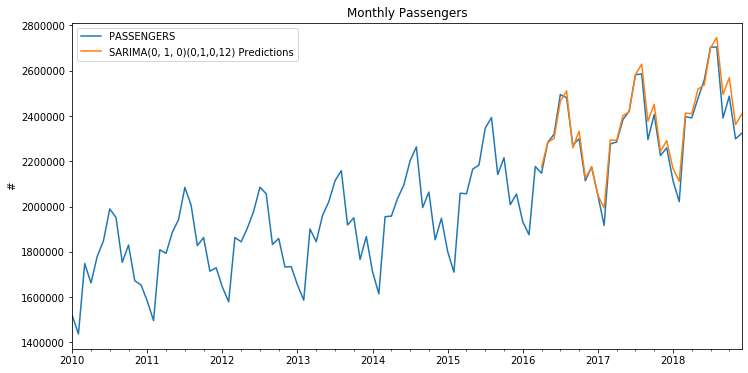

In [47]:
# Plot predictions against known values
title = 'Monthly Passengers'
ylabel='#'
xlabel=''

ax = df['PASSENGERS'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## SARIMAX with Exogenous Variables

In [168]:
# Variables
endog = total_monthly['PASSENGERS']
exog = total_monthly['temperature_mean']

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, exog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             PASSENGERS   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1910.078
Date:                Thu, 16 Jan 2020   AIC                           3828.156
Time:                        18:20:38   BIC                           3838.885
Sample:                    01-01-2010   HQIC                          3832.506
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
temperature_mean  1.101e+05   1.09e+04     10.107      0.000    8.87e+04    1.31e+05
ar.L1                0.8043      0.090      8.900      0.000       0.627       0.981
ma.L1                0.4443 

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [169]:
# Variables
endog = total_monthly['PASSENGERS']
# exog = total_monthly['temperature_mean']

# Fit the model
mod = sm.tsa.statespace.SARIMAX(endog, order=(1,0,1))
res = mod.fit(disp=False)
print(res.summary())

                           Statespace Model Results                           
Dep. Variable:             PASSENGERS   No. Observations:                  108
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1846.704
Date:                Thu, 16 Jan 2020   AIC                           3699.408
Time:                        18:21:04   BIC                           3707.454
Sample:                    01-01-2010   HQIC                          3702.670
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9981      0.005    205.817      0.000       0.989       1.008
ma.L1         -0.1702      0.133     -1.277      0.202      -0.431       0.091
sigma2      3.921e+13   2.39e-15   1.64e+28      0.0

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



### Test model on individual location

In [160]:
nycdf = df[df['city'] == 'New York City'].reset_index(drop=True)
nycdf.head()

,ds,city,PASSENGERS,Type,Month,Year,temperature_mean,precipitation,rain_days,pressure,cost_of_living_index,population,city_ascii,lat,lng,country,iso2,iso3
0,2010-01-01,New York City,2576743,Domestic,1,2010,0.6,53.0,4.0,1014.3,100.0,8190355.0,New York City,40.6943,-73.9249,United States,US,USA
1,2010-02-01,New York City,2287242,Domestic,2,2010,1.0,115.0,8.0,1008.1,100.0,8190355.0,New York City,40.6943,-73.9249,United States,US,USA
2,2010-03-01,New York City,3039797,Domestic,3,2010,8.9,243.0,11.0,1011.4,100.0,8190355.0,New York City,40.6943,-73.9249,United States,US,USA
3,2010-04-01,New York City,3169597,Domestic,4,2010,14.5,65.0,5.0,1013.1,100.0,8190355.0,New York City,40.6943,-73.9249,United States,US,USA
4,2010-05-01,New York City,3163910,Domestic,5,2010,19.0,74.0,5.0,1015.5,100.0,8190355.0,New York City,40.6943,-73.9249,United States,US,USA


In [ ]:
start=len(train)
end=len(train)+len(test)-1

predictions = results.predict(start=0, end=107, dynamic=False, typ='levels').rename('SARIMA(0, 1, 0)(0,1,0,12) Predictions')

